# **NYC Restaurant Inspections Viz**

Joe Lardie

September 2023

# **Imports**

In [1]:
#Numpy
import numpy as np

#Pandas
import pandas as pd

#Seaborn
import seaborn as sns

#matplotlib
import matplotlib.pyplot as plt
import plotly
%matplotlib inline

# Wordcloud
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

#Geospacial
import geopandas as gpd
import folium

#Sklearn preprocessing
from sklearn import preprocessing,set_config
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer

#Scipy
from scipy import stats
from scipy.stats import norm

# Warnings
import warnings
warnings.filterwarnings("ignore")
set_config(display = 'diagram')

# **Data Dictionary**
**DBA**	This field represents the name (doing business as) of the entity (restaurant); Public business name, may change at discretion of restaurant owner

**BORO**	Borough in which the entity (restaurant) is located.;• 1 = MANHATTAN • 2 = BRONX • 3 = BROOKLYN • 4 = QUEENS • 5 = STATEN ISLAND • Missing; NOTE: There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location

**BUILDING**  Building number for establishment (restaurant) location

**STREET**	Street name for establishment (restaurant) location

**ZIPCODE**	Zip code of establishment (restaurant) location

**PHONE**	Phone Number; Phone number provided by restaurant owner/manager

**CUISINE DESCRIPTION**	This field describes the entity (restaurant) cuisine. ; Optional field provided by provided by restaurant owner/manager

**INSPECTION DATE**	This field represents the date of inspection; NOTE: Inspection dates of 1/1/1900 mean an establishment has not yet had an inspection

**ACTION**	This field represents the actions that is associated with each restaurant inspection. ; • Violations were cited in the following area(s). • No violations were recorded at the time of this inspection. • Establishment re-opened by DOHMH • Establishment re-closed by DOHMH • Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed. • "Missing" = not yet inspected;

**VIOLATION CODE**	Violation code associated with an establishment (restaurant) inspection

**VIOLATION DESCRIPTION**Violation description associated with an establishment (restaurant) inspection

**CRITICAL FLAG**	Indicator of critical violation; "• Critical • Not Critical • Not Applicable"; Critical violations are those most likely to contribute to food-borne illness

**SCORE**Total score for a particular inspection; Scores are updated based on adjudication results

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

**GRADE DATE**	The date when the current grade was issued to the entity (restaurant)

**RECORD DATE**	The date when the extract was run to produce this data set

**INSPECTION TYPE** A combination of the inspection program and the type of inspection performed; See Data Dictionary for full list of expected values


## **Important Context**

RECORD DATE = (date of the data pull).

Restaurants that received no violations are represented by a single row and coded as having no violations using the ACTION field.

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

Keep in mind that thousands of restaurants start business and go out of business every year; only restaurants in an active status are included in the dataset.

Establishments are uniquely identified by their CAMIS (record ID) number.

# **Import Data**

In [2]:
# Loading NYC Restaraunt Data
rdf = pd.read_csv('rdf')

In [3]:
# Glance of inspection data
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229463 entries, 0 to 229462
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  229463 non-null  int64  
 1   DBA                    228839 non-null  object 
 2   BORO                   229463 non-null  object 
 3   BUILDING               229082 non-null  object 
 4   STREET                 229454 non-null  object 
 5   ZIPCODE                226710 non-null  float64
 6   CUISINE DESCRIPTION    227122 non-null  object 
 7   INSPECTION DATE        229463 non-null  object 
 8   ACTION                 227122 non-null  object 
 9   VIOLATION CODE         225938 non-null  object 
 10  VIOLATION DESCRIPTION  225938 non-null  object 
 11  CRITICAL FLAG          229463 non-null  object 
 12  SCORE                  218439 non-null  float64
 13  GRADE                  113164 non-null  object 
 14  GRADE DATE             104798 non-nu

- Grade date has the fewest amount of values

# **Data Cleaning**

## **Function to clean up names**

In [4]:
# Function to clean restaurant names
def clean_restaurant_name(name):
    # Check if the input is a string
    if isinstance(name, str):
        # Remove store numbers using regular expression
        cleaned_name = re.sub(r'#\d+', '', name)
        
        # Remove all numeric characters
        cleaned_name = re.sub(r'\d+', '', cleaned_name)
    
        # Remove leading and trailing whitespace
        cleaned_name = cleaned_name.strip()
    
        return cleaned_name
    else:
        return name  # Return the input unchanged for non-string values

# Apply the clean_restaurant_name function to the 'DBA' column
rdf['Cleaned Restaurant Name'] = rdf['DBA'].apply(clean_restaurant_name)

In [5]:
# checking missing data in data 
def check_missing_data(rdf):
    total = rdf.isnull().sum().sort_values(ascending = False)
    percent = (rdf.isnull().sum()/rdf.isnull().count()*100).sort_values(ascending = False)
    percent = percent.round(2).astype(str) + '%'
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data_result = check_missing_data(rdf)
missing_data_result.head()

,Total,Percent
GRADE DATE,124665,54.33%
GRADE,116299,50.68%
SCORE,11024,4.8%
VIOLATION DESCRIPTION,3525,1.54%
VIOLATION CODE,3525,1.54%


Grade, Score, and Grade date - missing a lot of data due to some places not yet receiving an inspection
DBA needs to reference CAMIS to ensure the situation surrounding the repeated rows
Inspection Type may be related to places not yet received an inspection


In [6]:
# Checking for duplicates
rdf.duplicated().sum()

6

In [7]:
# Checking out the Score column
rdf['SCORE'].describe()

count    218439.000000
mean         23.262838
std          17.698425
min           0.000000
25%          11.000000
50%          19.000000
75%          31.000000
max         168.000000
Name: SCORE, dtype: float64

In [8]:
# Checking most commomn inspection type
rdf['INSPECTION TYPE'].value_counts()

Cycle Inspection / Initial Inspection                          121767
Cycle Inspection / Re-inspection                                43225
Pre-permit (Operational) / Initial Inspection                   34701
Pre-permit (Operational) / Re-inspection                        10089
Administrative Miscellaneous / Initial Inspection                5798
Pre-permit (Non-operational) / Initial Inspection                3032
Pre-permit (Operational) / Compliance Inspection                 1691
Cycle Inspection / Reopening Inspection                          1410
Administrative Miscellaneous / Re-inspection                     1159
Cycle Inspection / Compliance Inspection                          945
Pre-permit (Operational) / Reopening Inspection                   756
Smoke-Free Air Act / Initial Inspection                           567
Trans Fat / Initial Inspection                                    419
Calorie Posting / Initial Inspection                              354
Inter-Agency Task Fo

## **Grade Date by Year**

In [9]:
# Convert the 'GRADE DATE' column to datetime type
rdf['GRADE DATE'] = pd.to_datetime(rdf['GRADE DATE'])

# Filter rows for the year 2016
desired_year = 2016 
filtered_df = rdf[rdf['GRADE DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 778 to 229182
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    247 non-null    int64         
 1   DBA                      247 non-null    object        
 2   BORO                     247 non-null    object        
 3   BUILDING                 237 non-null    object        
 4   STREET                   247 non-null    object        
 5   ZIPCODE                  184 non-null    float64       
 6   CUISINE DESCRIPTION      247 non-null    object        
 7   INSPECTION DATE          247 non-null    object        
 8   ACTION                   247 non-null    object        
 9   VIOLATION CODE           210 non-null    object        
 10  VIOLATION DESCRIPTION    210 non-null    object        
 11  CRITICAL FLAG            247 non-null    object        
 12  SCORE                    247 no

In [10]:
# Convert the 'GRADE DATE' column to datetime type
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'])

# Filter rows for the year
desired_year = 2023
filtered_df = rdf[rdf['INSPECTION DATE'].dt.year == desired_year]

# Display the rows for the specified year
print(filtered_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82597 entries, 76 to 229460
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CAMIS                    82597 non-null  int64         
 1   DBA                      82597 non-null  object        
 2   BORO                     82597 non-null  object        
 3   BUILDING                 82511 non-null  object        
 4   STREET                   82597 non-null  object        
 5   ZIPCODE                  81759 non-null  float64       
 6   CUISINE DESCRIPTION      82597 non-null  object        
 7   INSPECTION DATE          82597 non-null  datetime64[ns]
 8   ACTION                   82597 non-null  object        
 9   VIOLATION CODE           82151 non-null  object        
 10  VIOLATION DESCRIPTION    82151 non-null  object        
 11  CRITICAL FLAG            82597 non-null  object        
 12  SCORE                    78746

# **Feature Engineering**

### **Average Score by Borough**

In [11]:
# Feature engineering the average score for each borough
rdf['AVG_SCORE'] = rdf.groupby('BORO')['SCORE'].transform('mean')

### **Most Common Grade by Borough**

In [12]:
# Group by 'BORO' and find the most common grade for each group
def most_common_grade(x):
    if not x.empty:
        mode_values = x.mode()
        if not mode_values.empty:
            return mode_values.iat[0]
    return None

most_common_grade_by_boro = rdf.groupby('BORO')['GRADE'].agg(most_common_grade).reset_index()

# Rename the column to 'avg_grade'
most_common_grade_by_boro = most_common_grade_by_boro.rename(columns={'GRADE': 'avg_grade'})

# Merge the result back to the original DataFrame
rdf = pd.merge(rdf, most_common_grade_by_boro, on='BORO', how='left')

### **Most Common violation for Pizza Restaurants in each borough**

In [13]:
# Filter the DataFrame to include only 'Pizza' restaurants
pizza_df = rdf[rdf['CUISINE DESCRIPTION'] == 'Pizza']

# Group by 'BORO' and find the most common violation for each group
def most_common_violation(x):
    if not x.empty:
        mode_values = x.mode()
        if not mode_values.empty:
            return mode_values.iat[0]
    return None

most_common_violation_by_boro = pizza_df.groupby('BORO')['VIOLATION DESCRIPTION'].agg(most_common_violation).reset_index()

# Rename the column to 'most_common_violation_by_boro'
most_common_violation_by_boro = most_common_violation_by_boro.rename(columns={'VIOLATION DESCRIPTION': 'most_common_violation'})

# Merge the result back to the original DataFrame
rdf = pd.merge(rdf, most_common_violation_by_boro, on='BORO', how='left')

In [14]:
rdf['most_common_violation'].value_counts()

Non-food contact surface or equipment made of unacceptable material, not kept clean, or not properly sealed, raised, spaced or movable to allow accessibility for cleaning on all sides, above and underneath the unit.    229448
Name: most_common_violation, dtype: int64

### **Chain Indicator**

In [15]:
# Create a new column 'Restaurant Chain Indicator'
rdf['Chain Indicator'] = rdf['DBA'].duplicated(keep=False)

### **Full address**

In [16]:
# Create a new column 'Full Address'
rdf['Full Address'] = rdf['BUILDING'] + ' ' + rdf['STREET']

### **Top violation code**

In [17]:
# Top Violation Code
top_violations = rdf['VIOLATION CODE'].value_counts().head(3).index

for violation_code in top_violations:
    rdf[f'Has {violation_code} Violation'] = rdf['VIOLATION CODE'] == violation_code

### **Nearest Competitors**

In [18]:
# Nearest competitors
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'constant'
rdf[['Latitude', 'Longitude']] = imputer.fit_transform(rdf[['Latitude', 'Longitude']])

# Now, you can fit the NearestNeighbors model
cuisine_coords = rdf.groupby('CUISINE DESCRIPTION')[['Latitude', 'Longitude']].mean()
nbrs = NearestNeighbors(n_neighbors=1, metric='haversine').fit(cuisine_coords)

distances, indices = nbrs.kneighbors(rdf[['Latitude', 'Longitude']])
rdf['Distance to Nearest Competitor'] = distances

### **Most Common Month for inspections of pizza restaurants in each borough**

In [19]:
# Convert 'INSPECTION DATE' to datetime
rdf['INSPECTION DATE'] = pd.to_datetime(rdf['INSPECTION DATE'])

# Extract the month from 'INSPECTION DATE'
rdf['INSPECTION MONTH'] = rdf['INSPECTION DATE'].dt.month

# Filter the DataFrame to include only pizza restaurants
pizza_rdf = rdf[rdf['CUISINE DESCRIPTION'] == 'Pizza']

# Group by 'BORO' and find the most common inspection month for each group
most_common_inspection_month_by_boro = pizza_rdf.groupby('BORO')['INSPECTION MONTH'].agg(lambda x: x.mode().iat[0]).reset_index()

# Rename the column to 'most_common_inspection_month'
most_common_inspection_month_by_boro = most_common_inspection_month_by_boro.rename(columns={'INSPECTION MONTH': 'most_common_inspection_month'})

# Merge the result back to the original DataFrame
rdf = pd.merge(rdf, most_common_inspection_month_by_boro, on='BORO', how='left')

## **Merged DF**

In [20]:
# Loading NYC Restaraunt Data
mdf = pd.read_csv('mdf')

In [21]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CAMIS                  607 non-null    int64  
 1   DBA                    607 non-null    object 
 2   BORO                   607 non-null    object 
 3   BUILDING               607 non-null    object 
 4   STREET                 607 non-null    object 
 5   ZIPCODE                603 non-null    float64
 6   CUISINE DESCRIPTION    607 non-null    object 
 7   INSPECTION DATE        607 non-null    object 
 8   ACTION                 607 non-null    object 
 9   VIOLATION CODE         604 non-null    object 
 10  VIOLATION DESCRIPTION  604 non-null    object 
 11  CRITICAL FLAG          607 non-null    object 
 12  SCORE                  607 non-null    float64
 13  GRADE                  607 non-null    object 
 14  GRADE DATE             607 non-null    object 
 15  INSPEC

### **Size based on review counts**

In [22]:
# Define size categories
size_bins = [0, 50, 200, np.inf]
size_labels = ['Small', 'Medium', 'Large']

# Create 'Size Category' column
mdf['Size Category'] = pd.cut(mdf['review_count'], bins=size_bins, labels=size_labels)


### **Relative location**

In [23]:
# Assuming 'BORO' and 'review_count' columns are available
mdf['Relative Location'] = (mdf['review_count'] > mdf.groupby('BORO')['review_count'].transform('median')).astype(int)

# **Visualizations**

# **Average Score for Pizza Restaurants in each Borough**

In [24]:
# Filter the DataFrame to include only 'Pizza' restaurants
pizza_df = rdf[rdf['CUISINE DESCRIPTION'] == 'Pizza']

# Group by 'BORO' and calculate the average score for each group
avg_score_by_boro = pizza_df.groupby('BORO')['SCORE'].mean().reset_index()

# Display the DataFrame with the average score for pizza restaurants in each 'BORO'
print(avg_score_by_boro)

            BORO      SCORE
0          Bronx  21.039186
1       Brooklyn  24.029674
2      Manhattan  23.559113
3         Queens  22.005999
4  Staten Island  20.922423


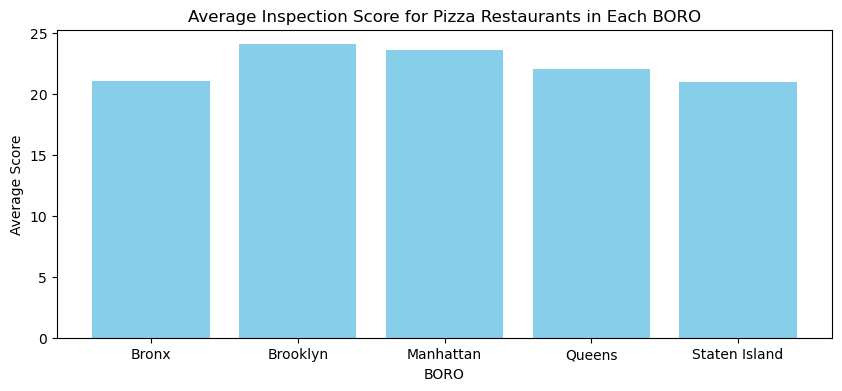

In [25]:
# Plotting the bar chart
plt.figure(figsize=(10, 4))
plt.bar(avg_score_by_boro['BORO'], avg_score_by_boro['SCORE'], color='skyblue')
plt.title('Average Inspection Score for Pizza Restaurants in Each BORO')
plt.xlabel('BORO')
plt.ylabel('Average Score')
plt.show()

## **Most Common Month for inspections of pizza restaurants in each borough**

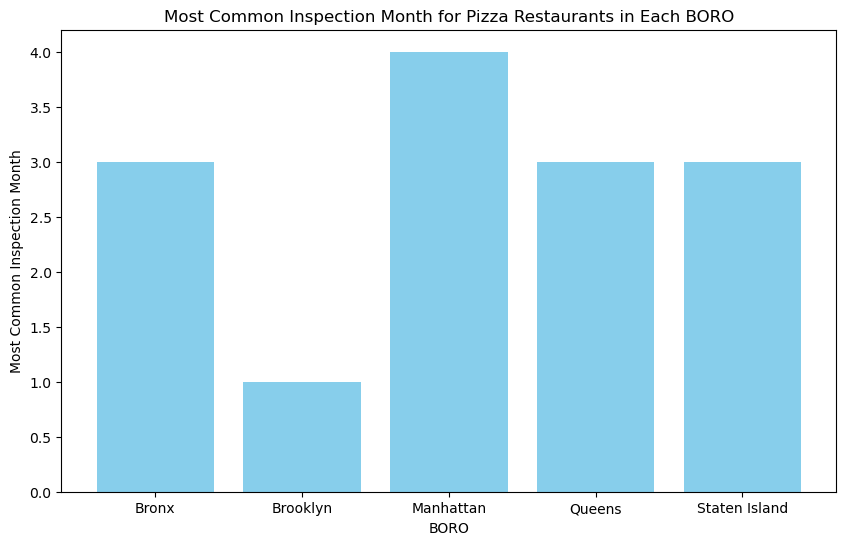

In [26]:
# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(most_common_inspection_month_by_boro['BORO'], most_common_inspection_month_by_boro['most_common_inspection_month'], color='skyblue')
plt.title('Most Common Inspection Month for Pizza Restaurants in Each BORO')
plt.xlabel('BORO')
plt.ylabel('Most Common Inspection Month')
plt.show()

## **Scores**

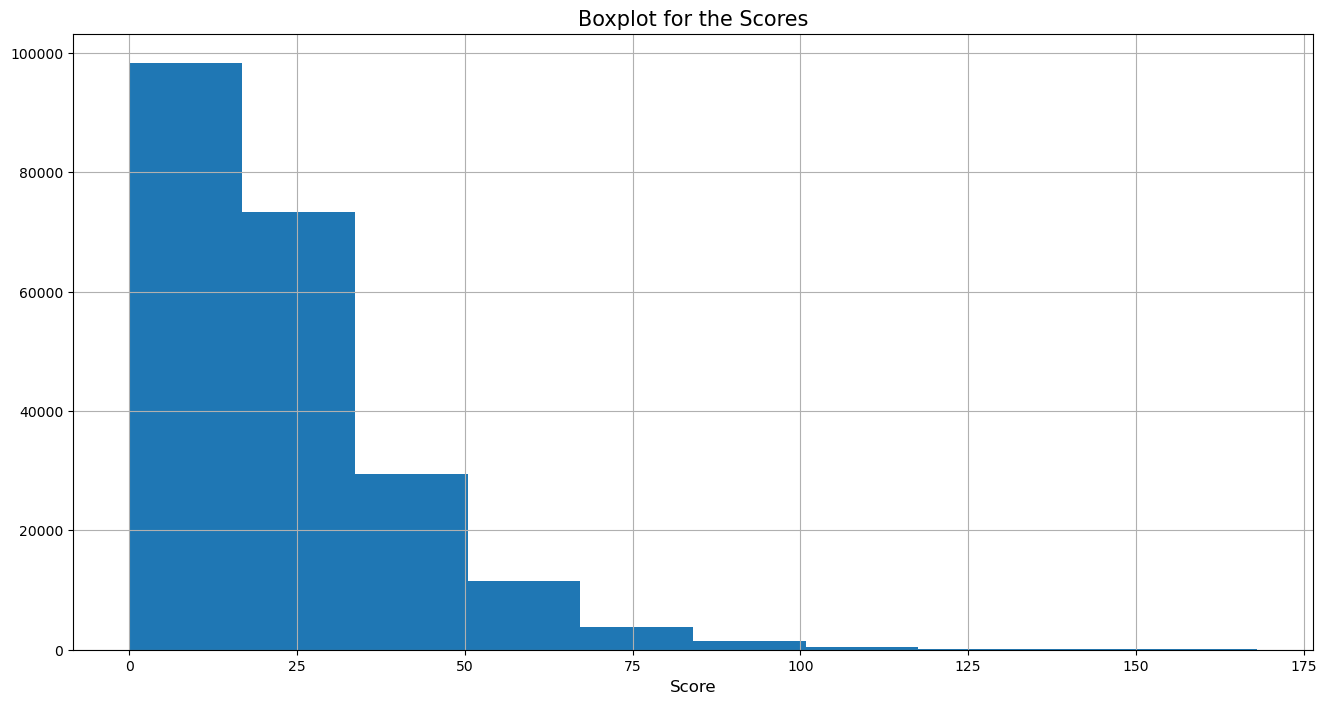

In [27]:
# Plot a histogram
rdf.SCORE.hist(figsize=(16,8))
plt.title("Boxplot for the Scores", fontsize=15)
plt.xlabel('Score', fontsize = 12);

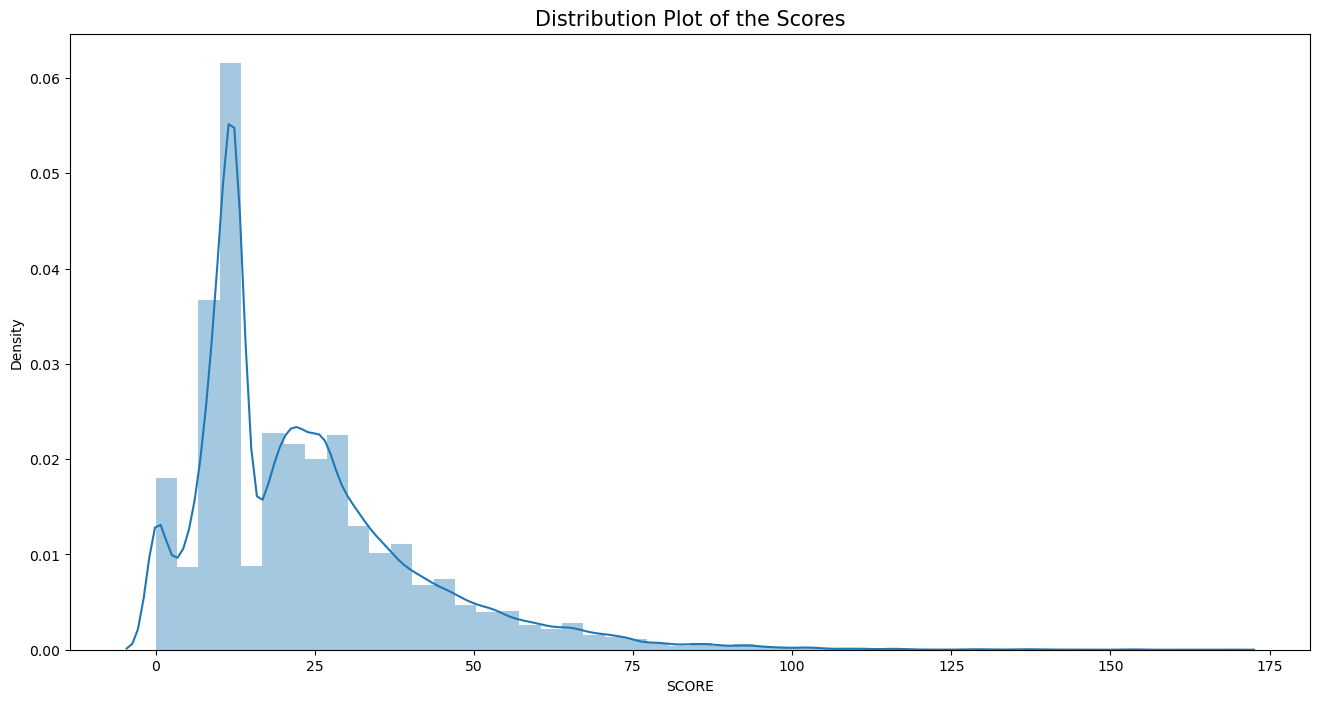

In [28]:
# Have a look at a distribution plot of the Score
fig, ax = plt.subplots()
fig.set_size_inches(16,8)
sns.distplot(rdf.SCORE.dropna())
plt.title("Distribution Plot of the Scores", fontsize=15);

## **NYC Boros**

### **Important Context:**

Establishments with inspection date of 1/1/1900 are new establishments that have not yet received an inspection.

In [29]:
# Filter rows where 'BORO' is 0
f_df = rdf[rdf['BORO'] != '0']

# Display the filtered DataFrame
print(f_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229448 entries, 0 to 229462
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   CAMIS                           229448 non-null  int64         
 1   DBA                             228832 non-null  object        
 2   BORO                            229448 non-null  object        
 3   BUILDING                        229076 non-null  object        
 4   STREET                          229448 non-null  object        
 5   ZIPCODE                         226704 non-null  float64       
 6   CUISINE DESCRIPTION             227122 non-null  object        
 7   INSPECTION DATE                 229448 non-null  datetime64[ns]
 8   ACTION                          227122 non-null  object        
 9   VIOLATION CODE                  225938 non-null  object        
 10  VIOLATION DESCRIPTION           225938 non-null  object 

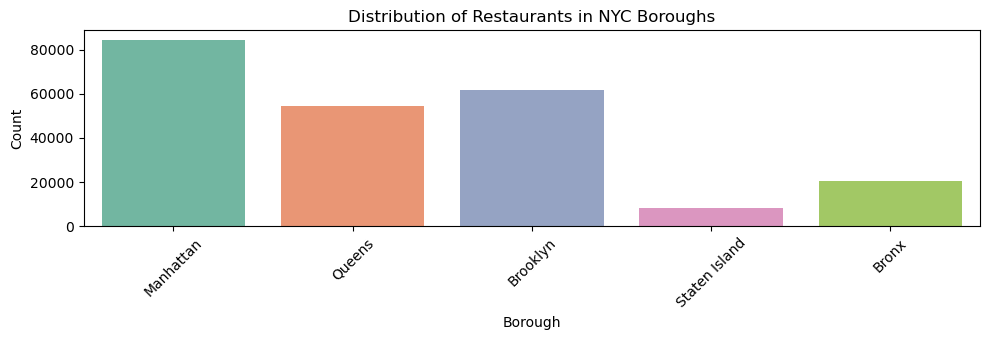

In [30]:
# Visualizing Distribution of Restaurants in NYC Boroughs
plt.figure(figsize=(10, 3.5))
sns.countplot(data=f_df, x='BORO', palette='Set2') 
plt.title('Distribution of Restaurants in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

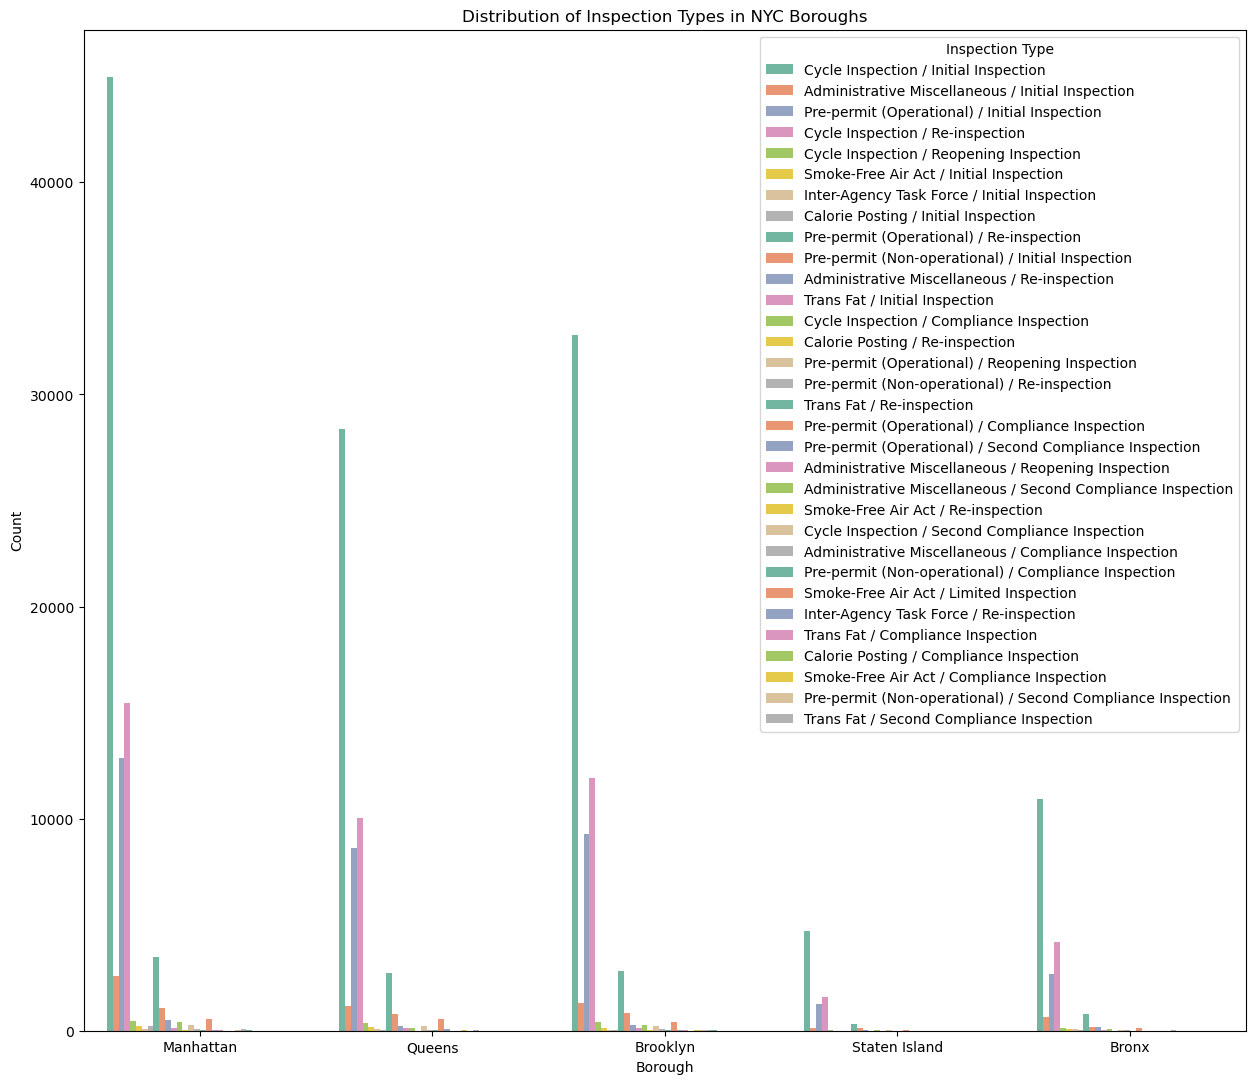

In [31]:
# Create a stacked bar chart using Seaborn
plt.figure(figsize=(15,13))
sns.countplot(x='BORO', hue='INSPECTION TYPE', data=f_df, palette='Set2')
plt.title('Distribution of Inspection Types in NYC Boroughs')
plt.xlabel('Borough')
plt.ylabel('Count')
# Show the plot
plt.legend(title='Inspection Type', bbox_to_anchor=(1, 1), loc='upper right')
plt.show()

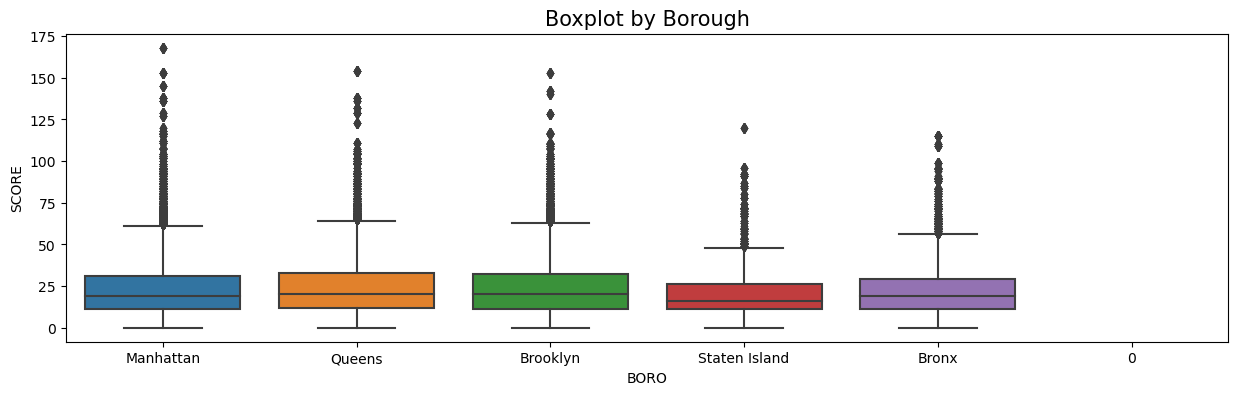

In [32]:
# Create a boxplot using Seaborn
fig, ax = plt.subplots()
fig.set_size_inches(15, 4)
sns.boxplot(x='BORO', y='SCORE', data=rdf)
plt.title('Boxplot by Borough', fontsize=15)

# Show the plot
plt.show()

## **Grade**

In [33]:
# Contingency table for Grade and Borough
boro_grade = pd.crosstab(rdf.GRADE, rdf.BORO, margins = True)
boro_grade

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island,All
GRADE,,,,,,
A,6580,20565,29518,18015,3426,78104
B,1382,3495,4420,3326,494,13117
C,679,2225,2718,2032,172,7826
N,657,1799,3361,2323,246,8386
P,70,205,208,167,17,667
Z,526,1290,1804,1306,138,5064
All,9894,29579,42029,27169,4493,113164


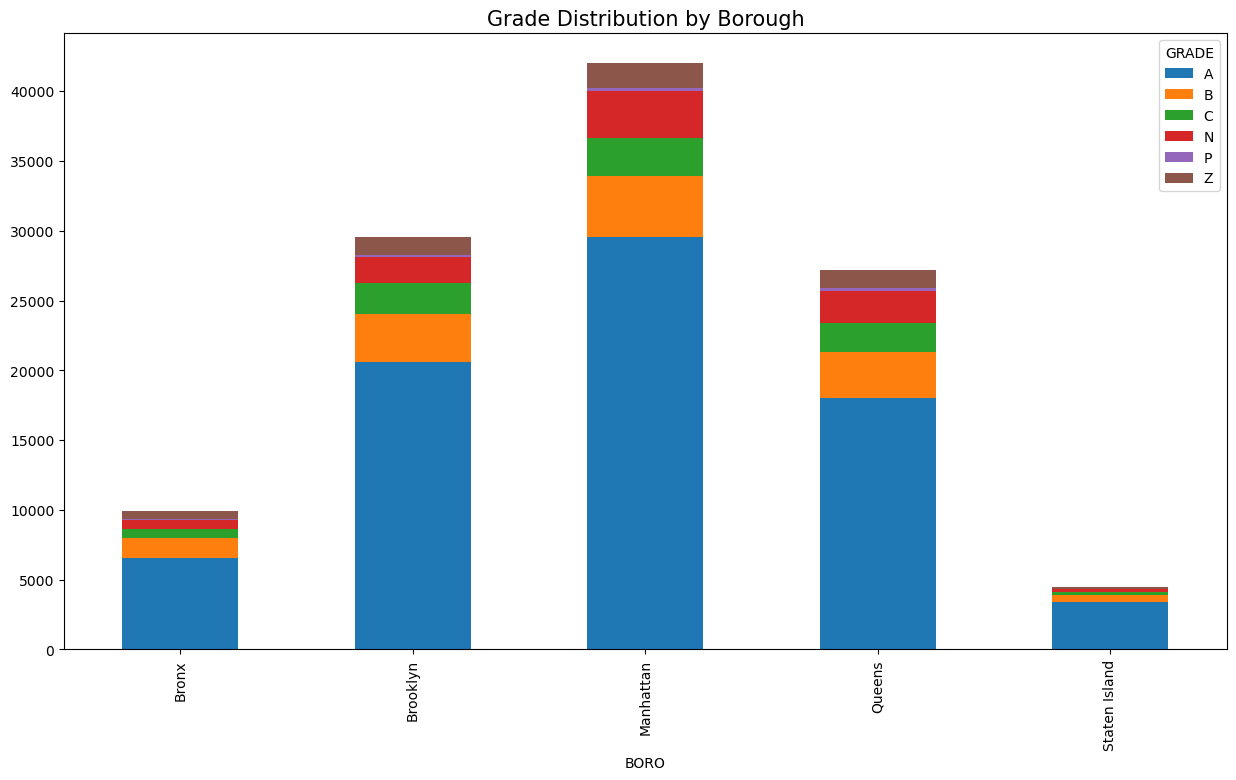

In [34]:
# Plot of grade by borough
pd.crosstab(rdf.BORO, rdf.GRADE).plot(kind="bar", figsize=(15,8), stacked=True)
plt.title('Grade Distribution by Borough', fontsize = 15);

## **Distribution of Grades**

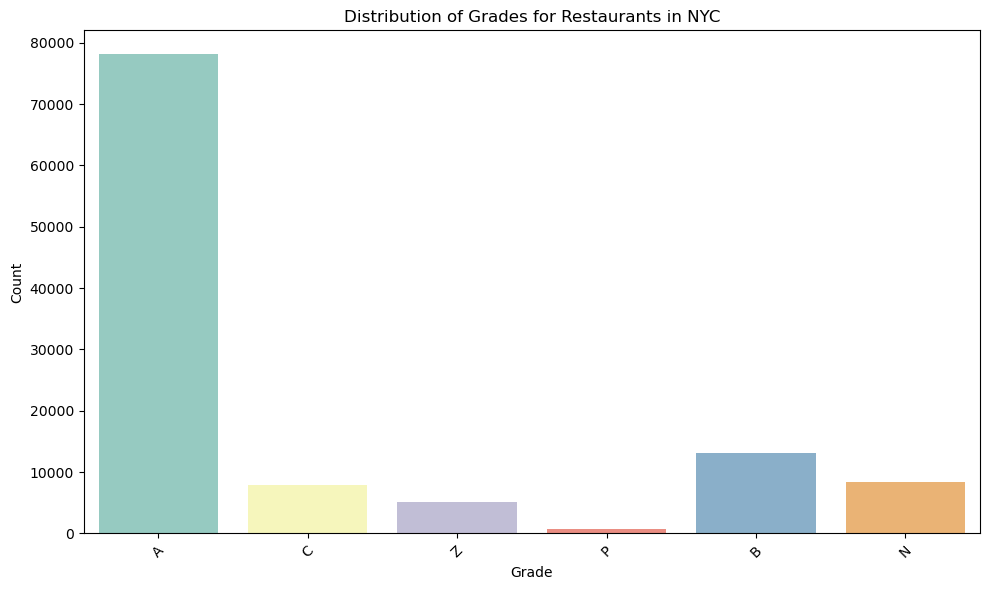

In [35]:
# Visualizing Distribution of Grades for Restaurants in NYC
plt.figure(figsize=(10, 6))
sns.countplot(data=rdf, x='GRADE', palette='Set3')  
plt.title('Distribution of Grades for Restaurants in NYC')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

**GRADE**	Grade associated with the inspection; • N = Not Yet Graded• A = Grade A• B = Grade B• C = Grade C• Z = Grade Pending• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

## **Distribution of Cuisine Types**

In [36]:
# Filteriung out the irrelevant Cuisine Types for Visalization
min_cuisine_count = 1000
cuisine_counts = rdf['CUISINE DESCRIPTION'].value_counts()
filtered_cuisines = cuisine_counts[cuisine_counts >= min_cuisine_count].index
fdf = rdf[rdf['CUISINE DESCRIPTION'].isin(filtered_cuisines)]

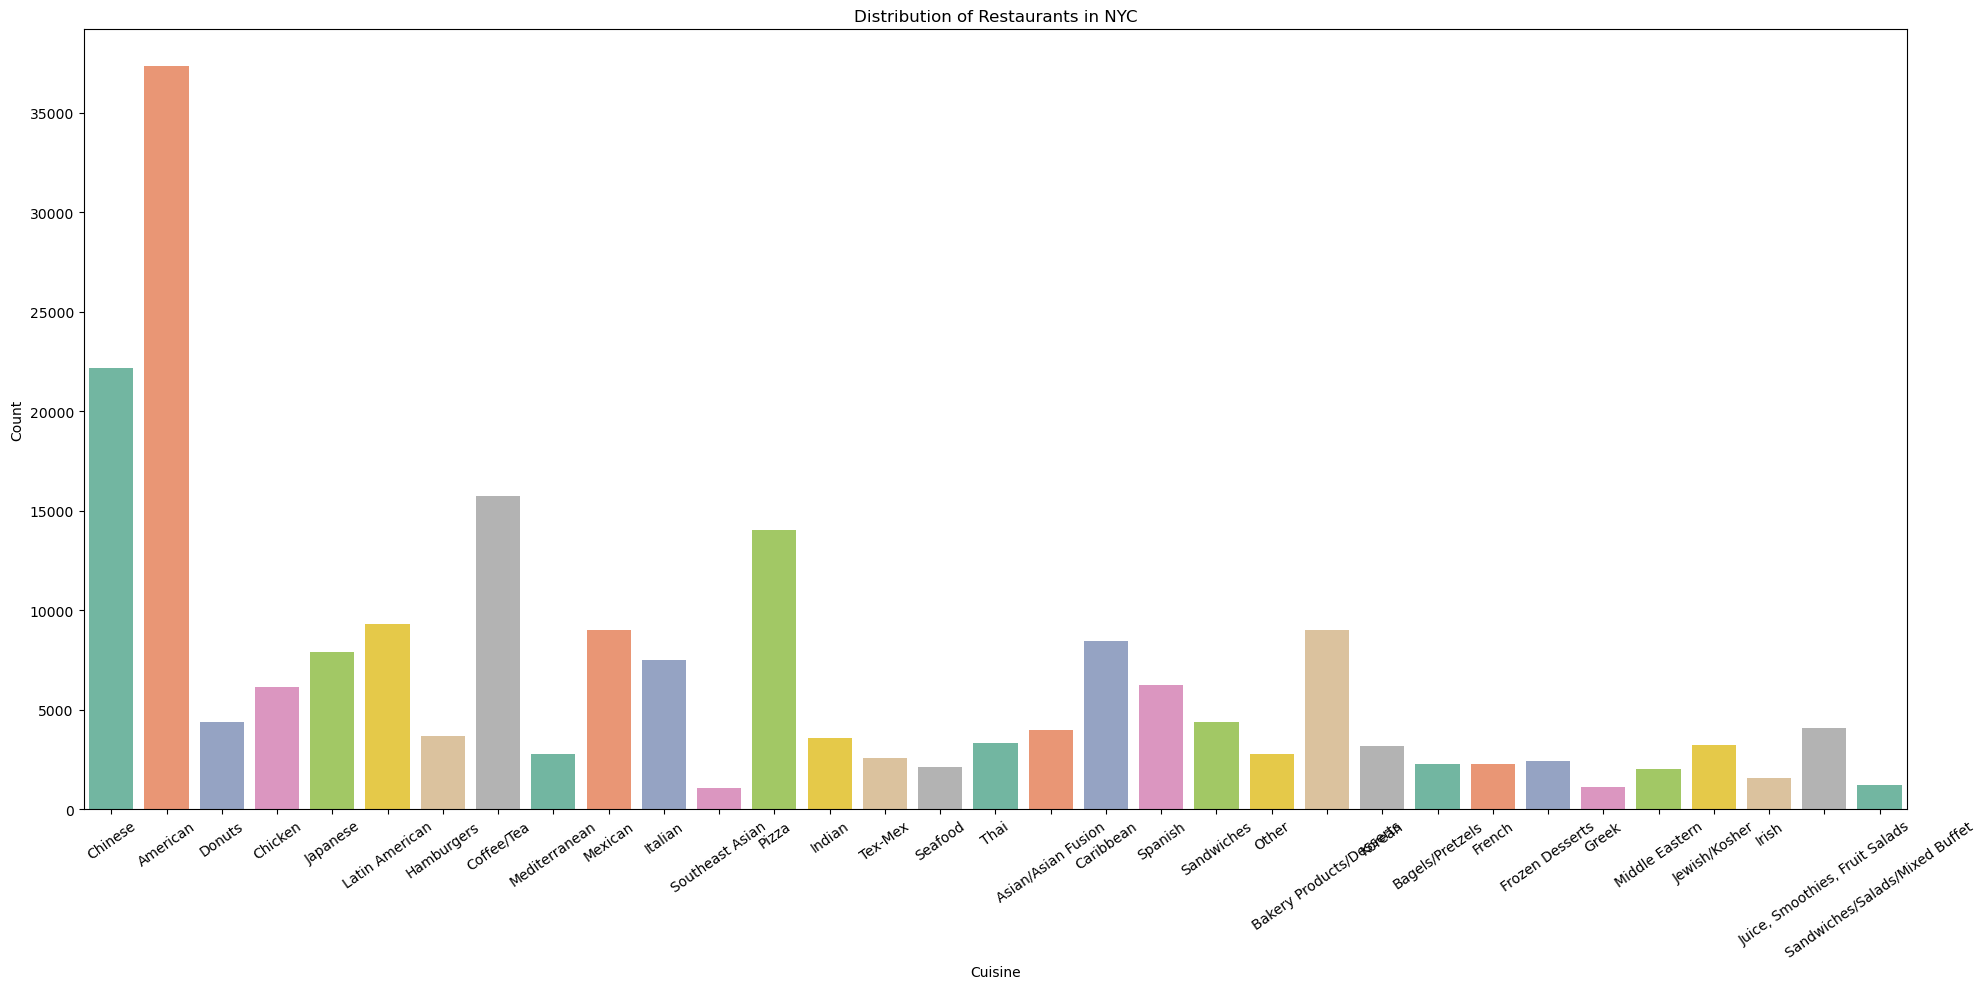

In [37]:
# Visualization of most popular cuisines
plt.figure(figsize=(20,10))
sns.countplot(data=fdf, x='CUISINE DESCRIPTION', palette='Set2') 
plt.title('Distribution of Restaurants in NYC')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.xticks(rotation=35) 

plt.tight_layout()
plt.show()

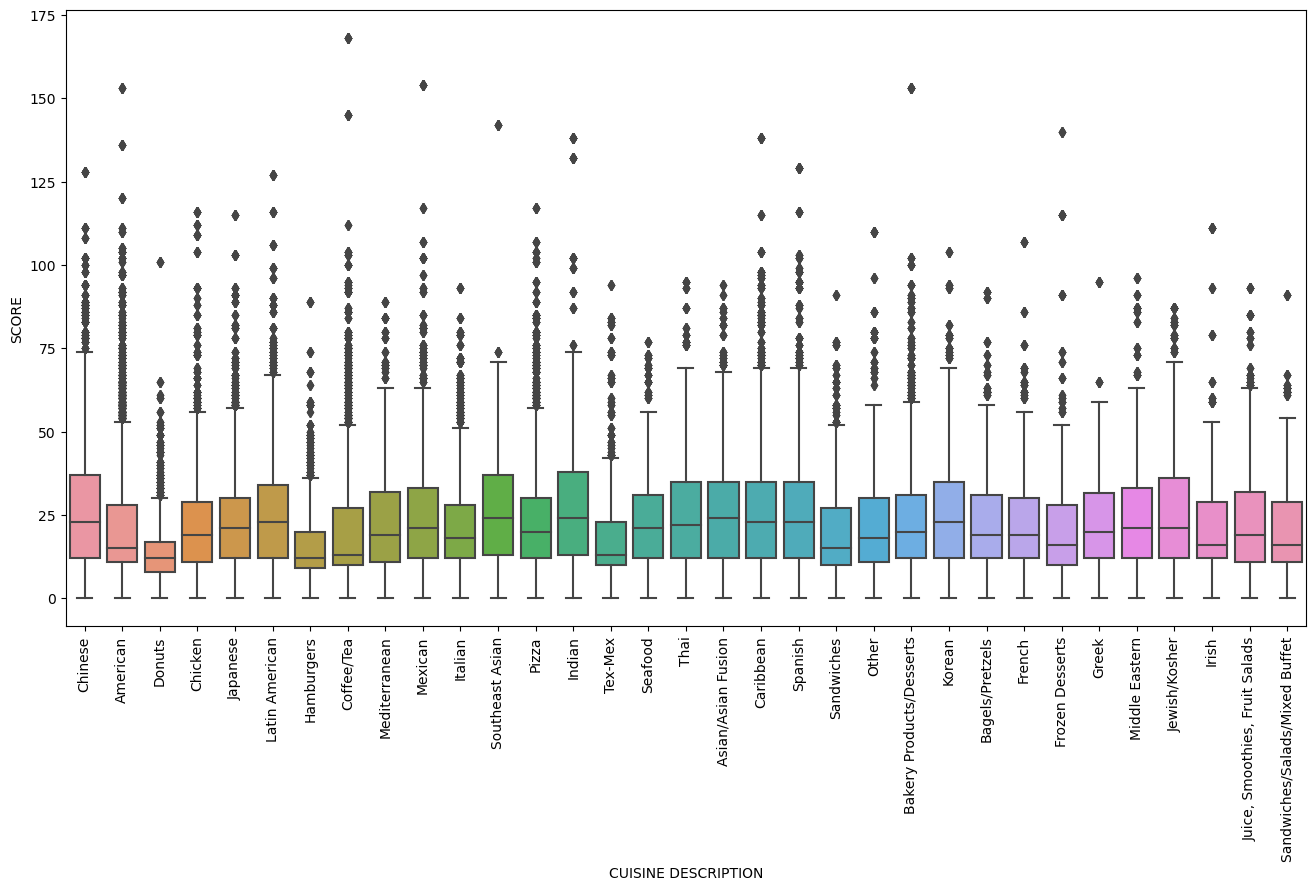

In [38]:
# Let us look at the scores by cuisine
score_cuisine = pd.concat([fdf['CUISINE DESCRIPTION'], fdf['SCORE']], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x = 'CUISINE DESCRIPTION', y="SCORE", data = fdf)
plt.xticks(rotation=90);

# **Text Visual**

In [39]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text  
    text = REPLACE_BY_SPACE_RE.sub(' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text    
    text = BAD_SYMBOLS_RE.sub('',text)# delete symbols which are in BAD_SYMBOLS_RE from text    
    temp = [s.strip() for s in text.split() if s not in STOPWORDS]# delete stopwords from text
    new_text = ''
    for i in temp:
        new_text +=i+' '
    text = new_text
    return text.strip()

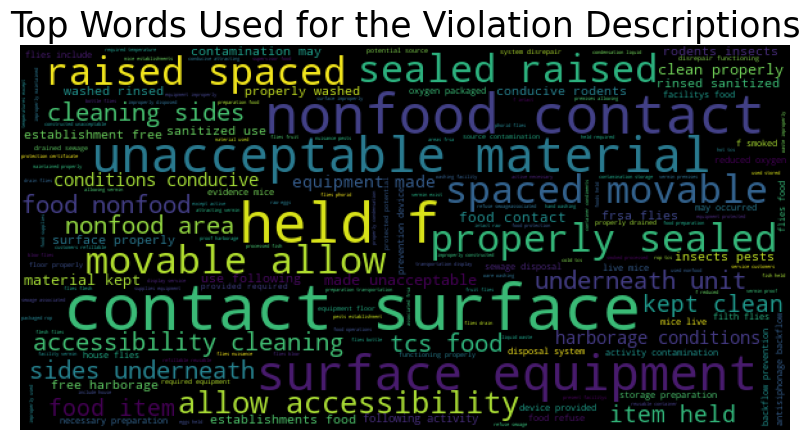

In [40]:
# Creating a word cloud for the violation description
temp_data = rdf.dropna(subset=['VIOLATION DESCRIPTION'])
# Converting into lowercase
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].apply(lambda x: " ".join(x.lower() for x in x.split()))
temp_data['VIOLATION DESCRIPTION'] = temp_data['VIOLATION DESCRIPTION'].map(text_prepare)
# Wordcloud visual for most used words for Violation Desriptions
wordcloud = WordCloud(max_font_size=50, width=600, height=300).generate(' '.join(temp_data['VIOLATION DESCRIPTION'].values))
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.title("Top Words Used for the Violation Descriptions", fontsize=25)
plt.axis("off")
plt.show()